In [1]:
## LIBRARIES
import pandas as pd 
import matplotlib.pyplot as plt
import math 
import random 
import networkx as nx

### Simulation Functions

In [338]:
## plotting distribution of interactions frequency per interaction distance 
def plot_distance_distribution(interactions):
    temp = []
    data = {}
    for row in interactions:
        temp.append(row[3])
    max_dist = max(temp)
    for i in range(max_dist+1):
        count = 0
        for row in interactions:
            if row[3] == i:
                count += 1
        data[i] = count
    x = list(data.keys())
    y= list(data.values())
    plt.bar(x, y, color = "green")
    plt.ylabel("frequency")
    plt.xlabel("distance of interaction")
    plt.title("Frequency of interactions per interaction distance ")

    
## plotting distribution of frequency of interactions per time step 
def plot_timestep_distribution(timesteps):
    data = {}
    for timestep, loi in timesteps.items():
        data[timestep] = len(loi)
    x = list(data.keys())
    y= list(data.values())
    plt.bar(x, y, color= "orange")
    plt.ylabel("frequency")
    plt.xlabel("timestep")
    plt.title("Frequency of interactions per time step ")
    


### creates a dictionary with key being integer(node) and value being a state of the SIR model
def create_dict(length, n):
    state_dict = {}
    states = ["S", "I", "R", "D", []]
    for i in range(1, length+1):
        state_dict[i] = [states[n], 0]
    return state_dict

### findind total # of nodes in a dataset formatted as Kisslers dataset (can be modified for other datasets)
def total_nodes(data):
    max_list = []
    for row in data:
        max_list.append(row[1])
        max_list.append(row[2])
    max_val = max(max_list)
    return max_val


## grouping time step interactions together for easy simulating later on // format dict[timestep] = [list of interactions at given timestep] 
def organize_interactions(data):
    time_steps = [[[]] for i in range(data[-1][0])]
    for row in data:
        time_steps[row[0]-1].append([row[1], row[2], row[3]])
    ts_dict = {}
    i = 1
    for l in time_steps:
        ts_dict[i] = l[1:]
        i+= 1
    return ts_dict

## infects given integers(nodes) from a state dict // key[integer] = "state" <-- format
def infect(state_dict, lon):
    temp_dict = state_dict
    for num in lon:
        temp_dict[num] = ["I", 0]
    return temp_dict


## counts the number of infections at a given time step 
def infections_count(state_dict):
    los = list(state_dict.values())
    count = 0
    for val in los:
        if val[0] == "I":
            count += 1
    return count

## counts the number of resistants at a given time step 
def resistant_count(state_dict):
    los = list(state_dict.values())
    count = 0
    for val in los:
        if val[0] == "R":
            count += 1
    return count

## counts the number of dead at a given time step 
def death_count(state_dict):
    los = list(state_dict.values())
    count = 0
    for val in los:
        if val[0] == "D":
            count += 1
    return count

## counts the number of susceptible at a given time step 
def susceptible_count(state_dict):
    los = list(state_dict.values())
    count = 0
    for val in los:
        if val[0] == "S":
            count += 1
    return count

## simulate a disease that can spread a certain distance with given initla nodes infected
def simulate_SIR(timesteps, infected_nodes, resistant_nodes, infection_duration, resistance_duration, prob_inf_mod_num, initial_probabilities):
    
    ## creating porbability distribution 
    probabilities = create_probabilities(prob_inf_mod_num, initial_probabilities)
    
    ## initializing dictionary that keeps track of nodes states and infecting it
    state = infect(create_dict(num_nodes, 0), infected_nodes)
    
    ##initializing variables
    num_infected = infections_count(state)
    num_res = resistant_count(state)
    num_dead = death_count(state)
    num_susc = susceptible_count(state)
    

    
    ## initializing timesteps data
    plot_data = [[0, num_infected, num_susc, num_res, num_dead, 0]]
    
    ## iterating thorugh all timesteps
    for timestep, loi in timesteps.items():
        infections_timestep = 0
        ## iterating through all interactions at a given timestep 
        for row in loi:
            
            ## extracting information, r_dist being the distance of interaction between node1 and node2
            node1 = row[0]
            node2 = row[1]
            r_dist = row[2]

            ## infection piece of code
            if ((state[node1][0] == "I" and state[node2][0] == "S") or (state[node2][0] == "S" and state[node1][0] == "I")):
                
                ## testing probability of infection at given distance
                if test_probability(r_dist, probabilities):
                    
                    infections_timestep += 1
                    
                    ## only infects and resets count of node that was "S"
                    if state[node1][0] == "I":
                        state[node2] = ["I", 0]
                    elif state[node2] == "I": 
                        state[node1] = ["I", 0]
                
        ##death or resistance code
        state = resistance_or_death(state, infection_duration, num_infected)
        
        ## reomving nodes with resistant exceeding threshold 
        state = remove_resistance(state, resistance_duration)
        
        ## updating variables for given time step
        num_infected = infections_count(state)
        num_res = resistant_count(state)
        num_dead = death_count(state)
        num_susc = susceptible_count(state)
        
        
        ## appending all data for later plotting
        plot_data.append([timestep, num_infected, num_susc, num_res, num_dead, infections_timestep])
        
        ## adding +1 to all time steps of all states
        state = add_timestep(state)
        
    return plot_data



## plots the infection and susceptability of the nodes during the experiment 
def plot_simulation(lol, infectious_duration):
    plt.figure(figsize=(15, 10))
    timesteps = []
    infections = []
    susc = []
    resistant = []
    dead= []
    ro = []
    for row in lol:
        timesteps.append(row[0])
        infections.append(row[1])
        susc.append(row[2])
        resistant.append(row[3])
        dead.append(row[4])
        ro.append(row[5])
    plt.plot(timesteps, infections, label="infected")
    plt.plot(timesteps, susc, label="susceptible")
    plt.plot(timesteps, resistant , label="resistant")
    plt.plot(timesteps, dead, label ="dead")
    plt.legend()
    plt.title("SIR MODEL SIMULATION", loc ='left')
    plt.xlabel("timesteps")
    plt.ylabel("number of people")
    plt.show()
    
    
    
def add_timestep(state):
    for node, val in state.items():
        state[node] = [val[0], val[1]+1]
    return state

def remove_resistance(state, resistance_duration):
    count = 0
    for node, val in state.items():
        if val[0] == "R" and val[1] >= resistance_duration:
            state[node] = ["S", 0]
            count += 1
    return state

def create_probabilities(n, initial_probabilities): ## this happens at beginnning of simulation, just used to
    infection_probabilities = []
    for val in initial_probabilities:
        prob = val + 5*n
        if prob < 0:
            prob = 0
        infection_probabilities.append(prob)
    return infection_probabilities

def test_probability(d, lop): ## this happens when theres an SI encounter, this adds probability of infection
    random_number = random.randint(1, 100)
    breaker = True
    range1 = 0
    range2 = 10
    i= 0
    while breaker:
        if d == 50:
            i = 4
            breaker = False
        elif d in range(range1, range2):
            breaker = False
        else: 
            range1 += 10
            range2 += 10
            i += 1
    if random_number < lop[i]:
        return True
    else:
        return False 
        

def resistance_or_death(state, infection_duration, infection_count):
    p_death = ((infection_count / num_nodes) * 100) + 3
    for node, items in state.items():
        if items[0] == "I" and items[1] >= infection_duration:
            if random.randint(1, 100) < p_death:
                state[node] = ["D", 0]
            else:
                state[node] = ["R", 0]
    return state 

def plot_ro(plot_data, infection_duration, thresh, single):
    new_infected = []
    timesteps = []
    for i in range(1, len(plot_data)):
        new_infected.append([plot_data[i][5], plot_data[i-1][1]])
        timesteps.append(plot_data[i][0])

    num_infected_per_individual = []
    for val in new_infected:
        try:
            num_infected_per_individual.append(val[0] / val[1] * infection_duration)
        except:
            num_infected_per_individual.append(0)
    avg_ro = []
    temp = 0
    i = 0
    n=0
    new_timesteps = [] 
    for val in num_infected_per_individual:
        if i == thresh:
            avg_ro.append(temp / i)
            new_timesteps.append(i/2 + i*n)
            temp = 0
            i = 0
            n += 1
        else:
            temp += val
            i += 1
        
    if single == 1:
        plt.scatter(new_timesteps, avg_ro, color = "green")
        plt.show()
        
    return [avg_ro, new_timesteps]


def dataset_creator(number_of_nodes, timesteps, num_interactions):
    listofnodes = set(list(range(1, number_of_nodes)))
    listofinteractions = []
    
    for timestep in range(1, timesteps):
        i = 0
        num_interactions = random.randint(100, 250)
        while i < num_interactions:
            i += 1

            tworandomnodes = random.sample(listofnodes, 2)
            listof1interaction = [timestep, tworandomnodes[0], tworandomnodes[1], random.randint(1, 50)]

            listofinteractions.append(listof1interaction)
            
    return listofinteractions


def analyze_data(interactions):
    print("Total number of interactions between people was:", len(interactions))

    ## plotting final interactions data to be used to simulate
    plot_distance_distribution(interactions)
    plt.show()

    # variable with total number of nodes
    num_nodes = total_nodes(interactions)

    ## creating dict of all interactions per time step // format dict[timestep] = [list of interactions at given timestep]
    timesteps = organize_interactions(interactions)
    
    ## plotting distribution of interactions per timestep
    plot_timestep_distribution(timesteps)
    
    return num_nodes


def create_graph(interactions):
    G = nx.Graph()

    for i in range(1, num_nodes):
        G.add_node(i)

    for interaction in interactions:
        G.add_edge(interaction[1], interaction[2], weight = interaction[3])
    return G
    

def degree_centrality(G, n):
    dc_dict = nx.algorithms.centrality.degree_centrality(G)
    sorted_dc = sorted(list(dc_dict.values()))
    bottom_five = sorted_dc[:n]
    top_five = sorted_dc[-n:]
    top_nodes = []
    bottom_nodes = []

    for node, score in dc_dict.items():
        if score in top_five:
            top_nodes.append((node, score))
        elif score in bottom_five:
            bottom_nodes.append((node, score))

    top_nodes = sorted(top_nodes[-n:], key=lambda x: x[1])
    bottom_nodes = sorted(bottom_nodes[:n], key=lambda x: x[1])
    out = [top_nodes, bottom_nodes]
    return out

def extract_nodes(los):
    out = []
    for val in los: 
        out.append(val[0])
    return out


def multi_plotter(lod, timesteps):
    plt.figure(figsize=(15, 10))
    i=0
    for val in lod:
        plt.plot(timesteps, val, label = i)
        i+=1
    plt.title("Ro performance over time for different infection probability ditributions")
    plt.xlabel("timesteps")
    plt.ylabel("Ro value")
    plt.legend()
    plt.show()
    


def multi_simulator(n, data, list_of_infected, list_of_resistant, infection_duration, resistance_duration, model_num, initial_probabilities):
    ro_lines = []
    for i in range(n):
        plot_data = simulate_SIR(data, 
                                 list_of_infected, 
                                 list_of_resistant, 
                                 infection_duration, 
                                 resistance_duration, 
                                 i, 
                                 initial_probabilities)
        
        r = plot_ro(plot_data, infection_duration, 30, 0)
        
        ro_lines.append(r[0])
        
    timesteps = r[1]
    
    multi_plotter(ro_lines, timesteps)


## Dataset Analysis

In [310]:
## reading csv data into a list 
df = pd.read_csv("Kissler_DataS1.csv")
data = df.values.tolist()

## removing interactions of distance 0m (as it is not realistic)
kissler_interactions = []
for row in data:
    if row[3] != 0:
        kissler_interactions.append(row)

In [314]:
### JUST USED FOR TESTING SOMETHING OUT 
interactions_extension = []
for val in interactions:
    interactions_extension.append([val[0] + 576, val[1], val[2], val[3]])
    
hybrid_interactions = kissler_interactions + interactions_extension ## adding double timesteps

In [280]:
###dataset_creator(number_of_nodes, timesteps, num_interactions):
sim_interactions = dataset_creator(450, 1000, 250) ## creating fake dataset

Total number of interactions between people was: 93529


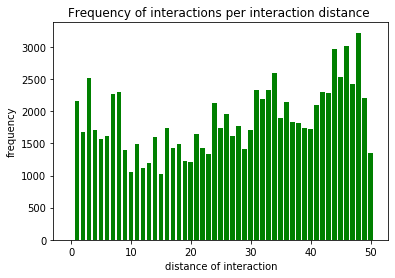

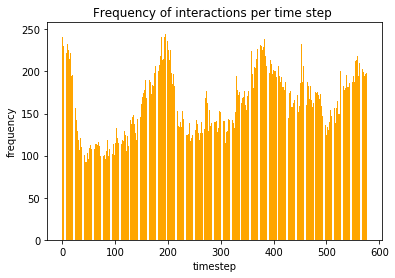

In [345]:
## kissler_interactions : original kissler dataset
## sim_interactions: fake dataset
## hybrid_interactions: original kissler dataset run twice (timestep 1 is the same as timestep 577 and so forth)


interactions = kissler_interactions ## either fake or kissler interactions

                       ### MAIN CODE TO CREATE AND ORGANIZE DATASET ###

num_nodes = analyze_data(interactions) ## printing info and finding num nodes total
timesteps = organize_interactions(interactions) ## organize interactions to dictionaty for simulation

## finding most and least important nodes based off of degree centrality 
most_important, least_important = degree_centrality(create_graph(interactions), 10)

##most important nodes based off of degree centrality
top_nodes = extract_nodes(most_important)
bottom_nodes = extract_nodes(least_important)

## ONLY THING YOU NEED TO CHANGE TO SIMULATE AND PLOT

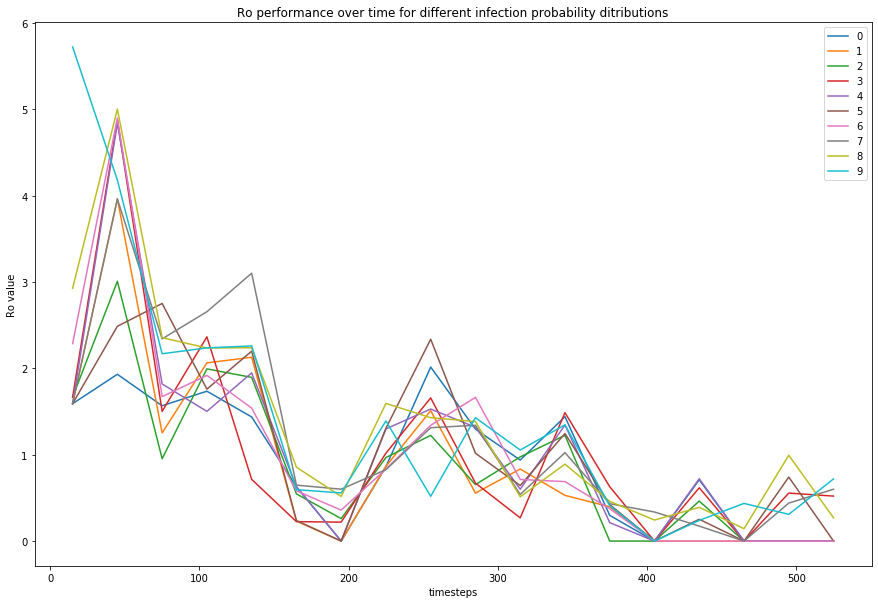

In [349]:
### PLOTTING Ro OVER TIME FOR DIFFERENT INFECTIION PROBABILITY DISTRIBUTIONS

## these are the only variables you need to touch to test out different parameters
data = timesteps
list_of_infected = top_nodes ## most important nodes based off of degree centrality                                                                                                                        
list_of_resistant = []
infection_duration = 250
resistance_duration = 250
initial_probabilities = [50, 0, -25, -37.5, -42.75]
model_num = 10 ## changes the initial probabilities by adding 10 * model_num to each index of list

## plotting all Ro values over time of all model numbers
multi_simulator(model_num, data, list_of_infected, list_of_resistant, infection_duration, resistance_duration, model_num, initial_probabilities)

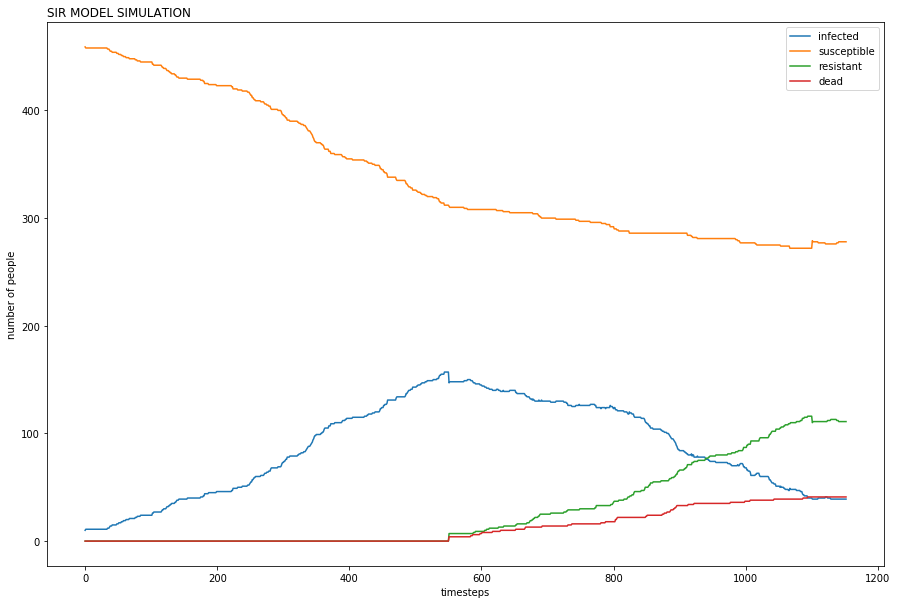

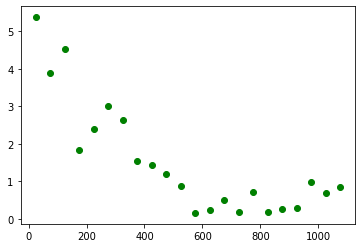

In [344]:
#### THIS CODE IS USED TO RUN SINGLE SIMULATIONS AND SEE GRAPH OVER TIME
model_num = 6 ## specify which model_num you want to observe

##collecting data
plot_data = simulate_SIR(        data, 
                                 list_of_infected, 
                                 list_of_resistant, 
                                 infection_duration, 
                                 resistance_duration, 
                                 model_num, 
                                 initial_probabilities)



## plotting simulation
plot_simulation(plot_data, infection_duration)

## plotting Ro value over time
r = plot_ro(plot_data, infection_duration, 50, 1)